In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from tqdm import tqdm
import os
import sys
import math

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from collections import defaultdict


if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")



There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
aa_inds = pd.read_csv('data/aa_inds.csv')
# b_blos = pd.read_csv('data/olga_big.csv', low_memory=False)
# b_blos.head()

In [3]:
from torch.nn.utils import spectral_norm


In [4]:
import torch.nn.functional as F


In [5]:
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(parent_dir)
sys.path.append(os.path.abspath(os.path.join(parent_dir, '..')))

In [6]:
sys.path.append(os.path.join('/home/akabalina', 'OLGA/olga'))
# sys.path

In [7]:
parent_dir

'/home/akabalina/nlp_tcr_predictor/tcremp_embs'

In [8]:
import olga.load_model as load_model
import olga.generation_probability as pgen
params_file_name = '/home/akabalina/OLGA/olga/default_models/human_T_beta/model_params.txt'
marginals_file_name = '/home/akabalina/OLGA/olga/default_models/human_T_beta/model_marginals.txt'
V_anchor_pos_file ='/home/akabalina/OLGA/olga/default_models/human_T_beta/V_gene_CDR3_anchors.csv'
J_anchor_pos_file = '/home/akabalina/OLGA/olga/default_models/human_T_beta/J_gene_CDR3_anchors.csv'
genomic_data = load_model.GenomicDataVDJ()
genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)

generative_model = load_model.GenerativeModelVDJ()
generative_model.load_and_process_igor_model(marginals_file_name)

pgen_model = pgen.GenerationProbabilityVDJ(generative_model, genomic_data)

In [9]:
def pgen_log(pgen_val):
    if pgen_val < 1e-20:
        pgen_val += 1e-20
    return round(math.log10(pgen_val), 5)

def encode_seq(seq):
    mtr = np.zeros((10, len(seq), 20))
    for factor in range(10):
        for aa_i in range(len(seq)):
            mtr[factor, aa_i, list(aa_inds[f'f{factor+1}']).index(seq[aa_i])] = 1
        
    return mtr

# Utils functions for GPU usage of neural networks
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
class SoftExponential(nn.Module):
    def __init__(self, alpha=-0.5, beta=1000.0):
        super(SoftExponential, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.beta = nn.Parameter(torch.tensor(beta))

    def forward(self, x):
        if self.alpha.item() < 0:
            return -1.0 * self.beta / self.alpha * (torch.exp(-self.alpha * x) - 1)
        elif self.alpha.item() == 0:
            return x * self.beta
        else:
            return 1.0 * self.beta / self.alpha * (torch.exp(self.alpha * x) - 1)

        

def decode_seq(pred, aa_inds=aa_inds, return_all=False, seq_length=15):
    pred_indices = pred.argmax(dim=3)  # [batch_size, 10, seq_len]
    
    pred_seqs = []
    for batch_idx in range(pred_indices.size(0)):
        decoded_sequence = []
        for pos in range(seq_length):
            aa_for_position = []
            for factor in range(10):
                aa_idx = pred_indices[batch_idx, factor, pos].item()
                aa_code = aa_inds[f'f{factor+1}'].iloc[aa_idx]
            
            decoded_sequence.append(aa_code)
            
        full_sequence = ''.join(decoded_sequence)
        # print(full_sequence)
        pgen = pgen_model.compute_aa_CDR3_pgen(full_sequence)
        pgen_val = pgen_log(pgen) if pgen > 0 else -20  # Защита от нуля
      
        pred_seqs.append((full_sequence, pgen_val))
    
    pred_seqs.sort(key=lambda x: x[1], reverse=True)
    
    if return_all:
        return pred_seqs
    return pred_seqs[0]

def plot_pgen_distribution(pgen):  
    sns.displot(pgen, kde=True, height=3, aspect=1.5)
    plt.xlabel('OLGA p_gen')
    plt.show()
    
def calculate_diversity(sequences, num_samples=100):
    sequences = list(map(lambda x: x[0], sequences))

    unique_seqs = set(sequences)
        
    diversity = len(unique_seqs) / len(sequences)
    return diversity

def histo_samples(latent_tensors, show=True):
    sample_pgenes = []
    fake_seqs = generator(latent_tensors)
    b_preds = fake_seqs.to('cpu')
    pgens = decode_seq(b_preds, return_all=True)
    sample_pgenes = list(map(lambda x: x[1], pgens))    
    
    if show:
        sns.displot(sample_pgenes, kde=True, height=3, aspect=1.5)
        plt.xlabel('OLGA p_gen')
        plt.show()
        
    return sorted(sample_pgenes)



In [10]:
batch_size = 256
latent_size = 1024

In [11]:
discriminator = nn.Sequential(
    spectral_norm(nn.Conv2d(10, 32, kernel_size=3, stride=1, padding=1, bias=False)),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),

    spectral_norm(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    spectral_norm(nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1, bias=False)),
    
    nn.Flatten(),
    nn.Linear(15, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    SoftExponential())

In [12]:

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.Dropout(0.3),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.Dropout(0.3),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.Dropout(0.3),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 10, kernel_size=(4, 5), stride=(1, 1), padding=(10, 8), bias=False),
    nn.Tanh()
)

In [13]:
discriminator.load_state_dict(torch.load("models3/discriminator_olga_big_real2.pth"))
# discriminator.eval()

generator.load_state_dict(torch.load("models3/generator_olga_big_real2.pth"))
# generator.eval()

<All keys matched successfully>

In [14]:
# discriminator = Discriminator()
discriminator = to_device(discriminator, device)

In [15]:
# generator = Generator(latent_size=latent_size)
generator = to_device(generator, device)

In [16]:
latent = torch.rand(batch_size, latent_size, 1, 1, device=device)

fake_images = generator(latent)


In [17]:
decode_seq(fake_images, return_all=True)

[('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGGLHGTEAFF', -9.41764),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSLGRLHGTEAFF', -9.78982),
 ('CASSL

In [18]:
latent = torch.rand(10, latent_size, 1, 1, device=device)

fake_images = generator(latent)


In [19]:
decode_seq(fake_images, return_all=True)

[('CASSLGRLDGTEAFF', -9.33986),
 ('CASSLGRLDETEAFF', -10.16196),
 ('CASSLGRLDETEAFF', -10.16196),
 ('CASSLGRLHETEAFF', -10.62755),
 ('CASSLGRLHETEAFF', -10.62755),
 ('CASSLGRLHETEAFF', -10.62755),
 ('CASSLGRLHETEAFF', -10.62755),
 ('CASSLGRLHETEAFF', -10.62755),
 ('CASSLGRLHETEAFF', -10.62755),
 ('GASSLGRLHGTEAFF', -20)]

In [17]:
history.keys()

dict_keys(['losses_g', 'losses_d', 'real_scores', 'fake_scores', 'diversity', 'all_pgen', 'opt_d', 'opt_g'])

In [11]:
import pickle

In [12]:
with open('logs/gan/covid_diploma/20250522-182104/history.pkl', 'rb') as f:
    history = pickle.load(f)

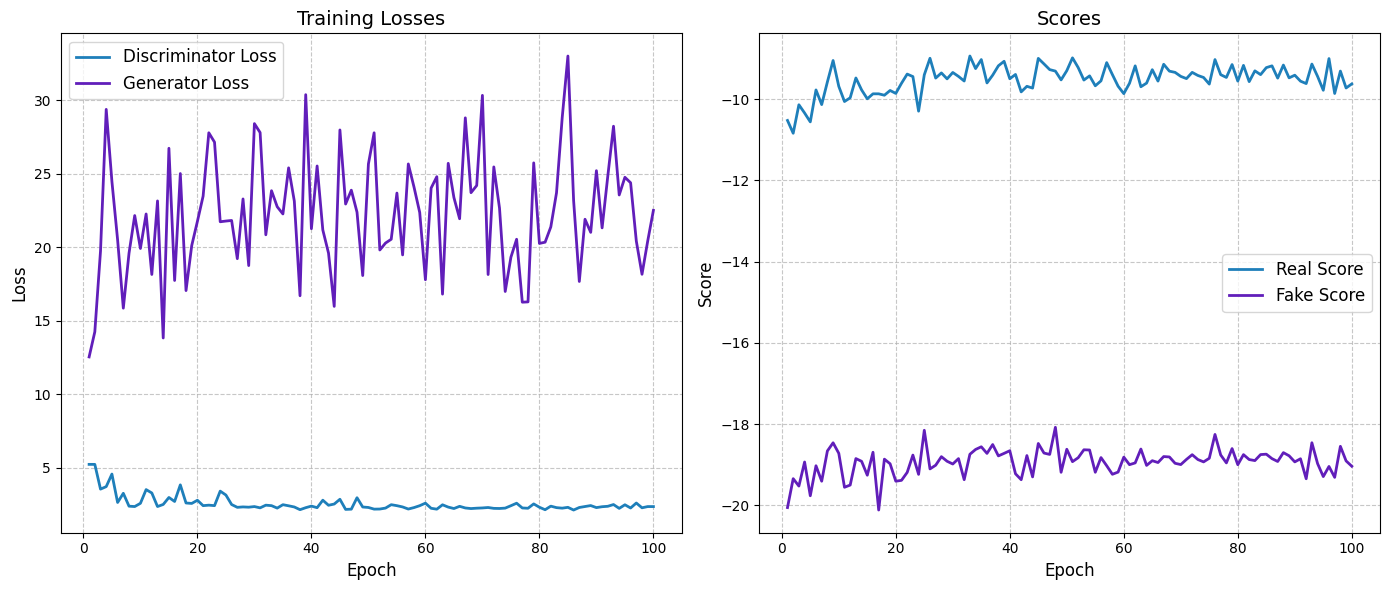

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    # Подготовка данных
    epochs = np.arange(1, len(history['losses_d']) + 1)
    
    # Создание фигуры с двумя subplots
    plt.figure(figsize=(14, 6))
    
    # График 1: Функции потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['losses_d'], color='#1e7fba', label='Discriminator Loss', linewidth=2)
    plt.plot(epochs, history['losses_g'], color='#611eba', label='Generator Loss', linewidth=2)
    # plt.plot(epochs, history['diversity'], label='diversity', linewidth=2)
    
    plt.title('Training Losses', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # График 2: Scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['real_scores'], color='#1e7fba', label='Real Score', linewidth=2)
    plt.plot(epochs, history['fake_scores'], color='#611eba', label='Fake Score', linewidth=2)
    
    plt.title('Scores', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    
    plt.tight_layout()
    # plt.savefig('models/learning.png')
    plt.show()


plot_training_history(history)

In [15]:
import statistics

statistics.median(history['all_pgen'][19])



-8.74921

In [16]:
history['diversity'][17]

0.71875

In [29]:
for i in range(70):
    if history['diversity'][i]>0.5:
        print('Epoch ', i)
        print('Div/mean', -10*history['diversity'][i]*statistics.mean(history['all_pgen'][i]))
        print('Div/median', -10*history['diversity'][i]*statistics.median(history['all_pgen'][i]))
        print('')

Epoch  0
Div/mean 83.79101562499999
Div/median 83.20519531250001

Epoch  1
Div/mean 125.03746464843749
Div/median 129.354184375

Epoch  2
Div/mean 75.11759277343751
Div/median 72.6071125

Epoch  3
Div/mean 78.28240078125
Div/median 76.326825

Epoch  4
Div/mean 53.433260546875
Div/median 54.54411875

Epoch  5
Div/mean 60.50494775390626
Div/median 60.573417187500006

Epoch  6
Div/mean 48.117274804687504
Div/median 47.62581875

Epoch  7
Div/mean 87.240882421875
Div/median 86.5027625

Epoch  10
Div/mean 78.387403125
Div/median 80.2256625

Epoch  11
Div/mean 52.600952636718745
Div/median 52.49795

Epoch  12
Div/mean 105.945544140625
Div/median 106.44786249999999

Epoch  13
Div/mean 54.99383935546875
Div/median 55.787859375

Epoch  15
Div/mean 71.172387890625
Div/median 72.464175

Epoch  17
Div/mean 56.636929492187505
Div/median 57.799862499999996

Epoch  18
Div/mean 92.52450468750001
Div/median 93.8493375

Epoch  19
Div/mean 47.781152929687494
Div/median 46.480178125

Epoch  21
Div/mean 64.

In [32]:
seqs = 'CASSLGGASGETQYF CASSLGGGSGETQYF CASSSSGGSYNEQFF CASSLSGGGTETQYF CASSPRGGGYNEQFF'
seqs = seqs.split()
for i in seqs:
    
    print(f'Sequence: {i}, log(pgen): {pgen_log(pgen_model.compute_aa_CDR3_pgen(i))}')

Sequence: CASSLGGASGETQYF, log(pgen): -8.04108
Sequence: CASSLGGGSGETQYF, log(pgen): -7.75677
Sequence: CASSSSGGSYNEQFF, log(pgen): -6.74063
Sequence: CASSLSGGGTETQYF, log(pgen): -8.06579
Sequence: CASSPRGGGYNEQFF, log(pgen): -6.83182


<AxesSubplot: >

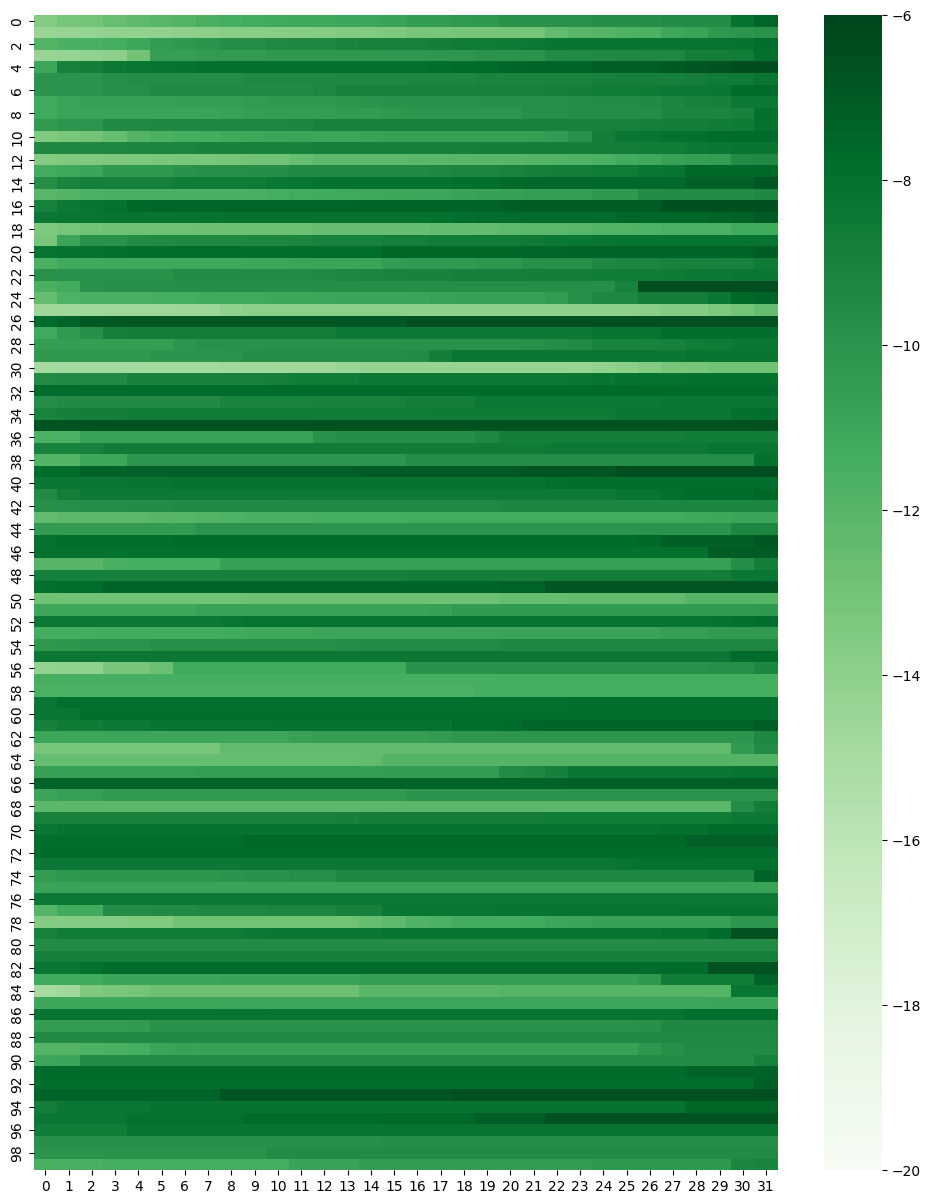

In [24]:
pgen_res_ = np.array([sorted(i) for i in history['all_pgen']])
plt.figure(figsize=(12, 15))
sns.heatmap(pgen_res_, cmap="Greens", vmin=-20, vmax=-6, annot=False)
# results_path = log_dir + '/results_big.png'
# plt.savefig(results_path)